<a href="https://colab.research.google.com/github/AylinNaebzadeh/MultiLabel-Text-Classification/blob/main/Mental_Health_Topic_Classification_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

- https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
- https://huggingface.co/bert-base-uncased
- https://huggingface.co/docs/transformers/model_doc/distilbert
-

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from torch.nn.functional import one_hot
import torch
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
label_dict = {
  'Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down': 0,
  'Feeling-down-depressed-or-hopeless': 1,
  'Feeling-tired-or-having-little-energy': 2,
  'Little-interest-or-pleasure-in-doing ': 3,
  'Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual': 4,
  'Poor-appetite-or-overeating': 5,
  'Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way': 6,
  'Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television': 7,
  'Trouble-falling-or-staying-asleep-or-sleeping-too-much': 8
}

In [ ]:
train_data = pd.read_csv("primate_data.csv")

In [ ]:
train_data.shape

(2003, 11)

In [ ]:
train_data.head()

,post_title,post_text,Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down,Feeling-down-depressed-or-hopeless,Feeling-tired-or-having-little-energy,Little-interest-or-pleasure-in-doing,Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual,Poor-appetite-or-overeating,Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way,Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television,Trouble-falling-or-staying-asleep-or-sleeping-too-much
0,I don't feel original anymore.,"When I was in high school a few years back, I ...",1,0.0,1,1,0,0.0,0.0,0.0,0
1,I don’t have anyone to talk to and I don’t kno...,Nine years ago I was diagnosed with depression...,1,1.0,0,0,1,0.0,0.0,0.0,0
2,Stuck between moving forward and killing myself,Some background information: My GF of almost 3...,1,1.0,1,1,0,0.0,1.0,0.0,0
3,I need help on how to help my girlfriend.,"My girlfriend ,of about 3 months now ,has been...",1,1.0,0,0,0,0.0,1.0,0.0,0
4,I've been feeling this way for some tine,I'm alway feeling like this. It doesn't even m...,1,1.0,0,0,0,0.0,0.0,0.0,0


In [ ]:
filter = (train_data["post_text"] != "") & (train_data["post_text"].notnull())
train_data = train_data[filter]
train_data = train_data.dropna()

In [ ]:
train_data.shape

(1997, 11)

In [ ]:
posts_labels = train_data[["Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down",
                           "Feeling-down-depressed-or-hopeless",
                           "Feeling-tired-or-having-little-energy",
                           "Little-interest-or-pleasure-in-doing ",
                           "Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual",
                           "Poor-appetite-or-overeating",
                           "Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way",
                           "Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television",
                           "Trouble-falling-or-staying-asleep-or-sleeping-too-much"]]

In [ ]:
posts_labels.head()

,Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down,Feeling-down-depressed-or-hopeless,Feeling-tired-or-having-little-energy,Little-interest-or-pleasure-in-doing,Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual,Poor-appetite-or-overeating,Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way,Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television,Trouble-falling-or-staying-asleep-or-sleeping-too-much
0,1,0.0,1,1,0,0.0,0.0,0.0,0
1,1,1.0,0,0,1,0.0,0.0,0.0,0
2,1,1.0,1,1,0,0.0,1.0,0.0,0
3,1,1.0,0,0,0,0.0,1.0,0.0,0
4,1,1.0,0,0,0,0.0,0.0,0.0,0


In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(train_data["post_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = posts_labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
len(X_train), len(X_test)

(1597, 400)

In [ ]:
data = {
    'train': {'texts': X_train, 'labels': torch.as_tensor(y_train)},
    'test': {'texts': X_test, 'labels': torch.as_tensor(y_test)},
}

# Functions

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, RobertaModel, RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes, bert_class):
    super(BERTClassifier, self).__init__()
    self.bert = bert_class.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [ ]:
class RobertaClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(RobertaClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [ ]:
from sklearn.metrics import f1_score

def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    predictions = []
    actual_labels = []
    loss_fn = torch.nn.BCEWithLogitsLoss()
    for batch in tqdm(data_loader, position=0):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # labels = batch['label'].to(device)
        labels = batch['label'].to(device)
        # labels_one_hot = one_hot(labels, num_classes).float()
        outputs = model(input_ids, attention_mask)
        # outputs = torch.sigmoid(outputs)
        # loss = loss_fn(outputs, labels_one_hot)
        # print('labels')
        # print(labels)
        # print('outputs')
        # print(outputs)
        # print(1 / 0)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        preds = torch.sigmoid(outputs) >= 0.5
        # preds = outputs >= 0.5
        predictions.extend(preds.cpu().tolist())
        # actual_labels.extend(labels_one_hot.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
    return f1_score(actual_labels, predictions, average='samples'), classification_report(actual_labels, predictions)


In [ ]:
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  actual_labels = []
  with torch.no_grad():
    for batch in tqdm(data_loader, position=0):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      # labels_one_hot = one_hot(labels, num_classes).float()
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.sigmoid(outputs) >= 0.5
      predictions.extend(preds.cpu().tolist())
      actual_labels.extend(labels.cpu().tolist())
  return f1_score(actual_labels, predictions, average='samples'), classification_report(actual_labels, predictions)

In [ ]:
# این بخش باید تغییر کنه چون طبیعتا چند لیبل داریم برای دیتاست فعلی
def predict_emoji(text, model, tokenizer, device, max_length=128):
  model.eval()
  encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # print(torch.sigmoid(outputs))
    preds = torch.sigmoid(outputs) >= 0.5
    preds = preds.type(torch.uint8)
    if 1 not in preds:
      label = 'OTHER'
    else:
      _, label = torch.max(outputs, dim=1)
      label = list(label_dict.keys())[label.item()]
    return label, preds

In [ ]:
def main(data, language_model, layer=None, tokenizer_class=BertTokenizer, bert_class=BertModel):
  tokenizer = tokenizer_class.from_pretrained(language_model)
  train_dataset = TextClassificationDataset(data['train']['texts'], data['train']['labels'], tokenizer, max_length)
  val_dataset = TextClassificationDataset(data['test']['texts'], data['test']['labels'], tokenizer, max_length)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = BERTClassifier(language_model, num_classes, bert_class).to(device)

  if layer:
    # freeze bert parameters
    for name, param in model.named_parameters():
      if layer in name: # classifier layer
        break
      param.requires_grad = False

  optimizer = AdamW(model.parameters(), lr=learning_rate)
  total_steps = len(train_dataloader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  reports = {'train': list(), 'val': list()}
  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_accuracy, train_report = train(model, train_dataloader, optimizer, scheduler, device)
    train(model, train_dataloader, optimizer, scheduler, device)
    val_accuracy, val_report = evaluate(model, val_dataloader, device)
    print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-'*20)
    reports['val'].append([val_accuracy, val_report])
    reports['train'].append([train_accuracy, train_report])
  print(val_report)
  return reports, model, tokenizer, device

In [ ]:
def plot_report(reports):
  val = [i[0] for i in reports['val']]
  train = [i[0] for i in reports['train']]
  x = range(len(val))

  plt.plot(x, train, label='train')
  plt.plot(x, val, label='val')
  plt.legend()

In [ ]:
num_classes = 9
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

https://huggingface.co/xlm-roberta-large-finetuned-conll03-english#model-details

# XLM-RoBERTa

In [ ]:
xlm_roberta_large_languge_model = 'xlm-roberta-large-finetuned-conll03-english'

In [ ]:
xlm_roberta_large_reports, xlm_roberta_large_model, xlm_roberta_large_tokenizer, xlm_roberta_large_device = main(data,
                                                                                                                 xlm_roberta_large_languge_model,
                                                                                                                 layer='23',
                                                                                                                 tokenizer_class=XLMRobertaTokenizer,
                                                                                                                 bert_class=XLMRobertaModel)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 100/100 [00:44<00:00,  2.25it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-sco

Train Accuracy: 0.6235, Validation Accuracy: 0.6176
Validation Accuracy: 0.6176
--------------------
Epoch 2/4


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 100/100 [00:44<00:00,  2.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Train Accuracy: 0.6269, Validation Accuracy: 0.6168
Validation Accuracy: 0.6168
--------------------
Epoch 3/4


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 100/100 [00:43<00:00,  2.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Train Accuracy: 0.6268, Validation Accuracy: 0.6168
Validation Accuracy: 0.6168
--------------------
Epoch 4/4


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 100/100 [00:44<00:00,  2.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-23-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Train Accuracy: 0.6275, Validation Accuracy: 0.6168
Validation Accuracy: 0.6168
--------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       338
           1       0.85      1.00      0.92       339
           2       0.00      0.00      0.00       139
           3       0.39      0.05      0.08       190
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00       161
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00        75

   micro avg       0.83      0.48      0.61      1418
   macro avg       0.23      0.23      0.21      1418
weighted avg       0.46      0.48      0.45      1418
 samples avg       0.84      0.52      0.62      1418




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


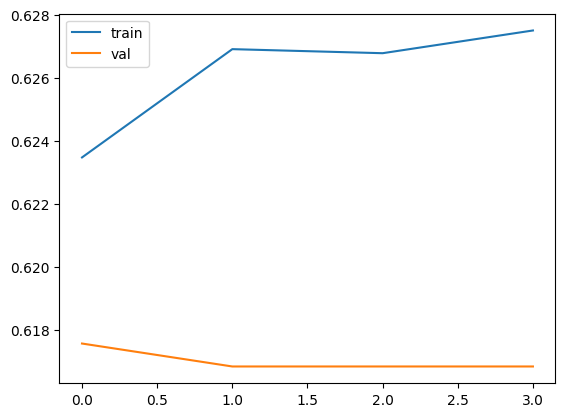

In [ ]:
plot_report(xlm_roberta_large_reports)

# BERT uncased

In [ ]:
num_classes = 9
max_length = 128
batch_size = 16
num_epochs = 1
learning_rate = 2e-5

In [ ]:
bertـlanguge_model = 'bert-base-uncased'

In [ ]:
bertـreports, bertـmodel, bertـtokenizer, bertـdevice = main(data, bertـlanguge_model, layer='11')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-17-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 25/25 [02:53<00:00,  6.95s/it]

Validation Accuracy: 0.6391
--------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       338
           1       0.85      1.00      0.92       339
           2       0.00      0.00      0.00       139
           3       0.54      0.43      0.48       190
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00       161
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00        75

   micro avg       0.80      0.54      0.64      1418
   macro avg       0.25      0.27      0.26      1418
weighted avg       0.48      0.54      0.50      1418
 samples avg       0.81      0.57      0.64      1418




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f"The BERT results are: {bertـreports}")

The BERT results are: {'train': [], 'val': [[0.6390793650793651, '              precision    recall  f1-score   support\n\n           0       0.84      1.00      0.92       338\n           1       0.85      1.00      0.92       339\n           2       0.00      0.00      0.00       139\n           3       0.54      0.43      0.48       190\n           4       0.00      0.00      0.00        97\n           5       0.00      0.00      0.00        37\n           6       0.00      0.00      0.00       161\n           7       0.00      0.00      0.00        42\n           8       0.00      0.00      0.00        75\n\n   micro avg       0.80      0.54      0.64      1418\n   macro avg       0.25      0.27      0.26      1418\nweighted avg       0.48      0.54      0.50      1418\n samples avg       0.81      0.57      0.64      1418\n']]}


ValueError: ignored

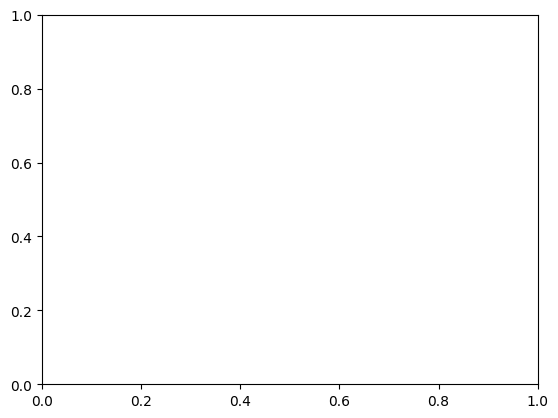

In [ ]:
plot_report(bertـreports)

# DistilBERT

In [ ]:
distil_bert__language_model = 'distilbert-base-uncased'

In [ ]:
distilbert_reports = main(data, distil_bert__language_model, layer='9')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.3.attention.self.key.weight', 'encoder.layer.4.output.dense.bias', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.bias', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.2.attention.self.query.weight', 'encoder.layer.10.attention.output.LayerNorm.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.8.output.dense.weight', 'encoder.layer.1.attention.output.dense.bias', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.9.intermediate.dense.weight', 'encoder.layer.11.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.5.attention.self.key.weight', 'encoder.la

Epoch 1/1


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-17-64ae45ba6aa6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}
100%|██████████| 25/25 [02:50<00:00,  6.81s/it]

Validation Accuracy: 0.6163
--------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       338
           1       0.85      1.00      0.92       339
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00       190
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00       161
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00        75

   micro avg       0.85      0.48      0.61      1418
   macro avg       0.19      0.22      0.20      1418
weighted avg       0.40      0.48      0.44      1418
 samples avg       0.85      0.52      0.62      1418




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f"The Distil BERTs results are: {distilbert_reports}")

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


The Distil BERTs results are: ({'train': [], 'val': [[0.6163356782106783, '              precision    recall  f1-score   support\n\n           0       0.84      1.00      0.92       338\n           1       0.85      1.00      0.92       339\n           2       0.00      0.00      0.00       139\n           3       0.00      0.00      0.00       190\n           4       0.00      0.00      0.00        97\n           5       0.00      0.00      0.00        37\n           6       0.00      0.00      0.00       161\n           7       0.00      0.00      0.00        42\n           8       0.00      0.00      0.00        75\n\n   micro avg       0.85      0.48      0.61      1418\n   macro avg       0.19      0.22      0.20      1418\nweighted avg       0.40      0.48      0.44      1418\n samples avg       0.85      0.52      0.62      1418\n']]}, BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (posit

In [ ]:
plot_report(distilbert_reports)

TypeError: ignored